In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # cuda 사용시 check 필요1


In [2]:
import tensorflow as tf
import numpy as np

## real dataset sample 생성하기

- QA Test <br>
    https://towardsdatascience.com/question-answering-with-pretrained-transformers-using-pytorch-c3e7a44b4012 <br>
    https://medium.com/@patonw/question-answering-with-pytorch-transformers-part-1-8736196bf20e <br>
    https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/ <br>
    
    - dataset <br>
        : Question, Context -> Answer <br>
         [START] QuestionContext(word_token) + 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 (type_token) + (position_token) <br>
         [START] Answer(word_token) [END]

### BERT Tokenizer

In [3]:
import transformers

In [4]:
# transformers.BERT_PRETRAINED_CONFIG_ARCHIVE_MAP

In [5]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
# [i for i in dir(transformers) if 'BERT' in i]

In [7]:
tokenizer.encode_plus('hey','save', return_special_tokens_mask=True)

{'input_ids': [101, 4931, 102, 3828, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'special_tokens_mask': [1, 0, 1, 0, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [8]:
tokenizer.vocab_size

30522

### SQuAD
- BERT에서 test했던 QA 데이터셋
    https://rajpurkar.github.io/SQuAD-explorer/

In [9]:
import json
with open('train-v2.0.json', 'r') as f:
    squad_train = json.load(f)

In [10]:
squad_train.keys()

dict_keys(['version', 'data'])

In [11]:
squad_train['version']

'v2.0'

In [12]:
# len(squad_train['data']), len(squad_train['data'][0]['paragraphs']), squad_train['data'][0]

In [13]:
# squad_train['data'][0]['paragraphs'][0]

In [14]:
from tqdm import tqdm
ids_dic = {}
dataset = []
for data in tqdm(squad_train['data']):
    for paragraphs in data['paragraphs']:
        context = paragraphs['context']
        questions = []
        anwers = []
        for gas in paragraphs['qas']:
            if gas['is_impossible'] == True: # classification 같이 할 때 고민
                continue
            ## padding 해줘야할까?
            # {'input_ids': [101, 4931, 102, 3828, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}
            X = tokenizer.encode_plus(gas['question'], context, padding='max_length', truncation=True, max_length=128)
            Y = tokenizer.encode_plus(gas['answers'][0]['text'], padding='max_length', truncation=True, max_length=32)
            idx = gas['id']
            ids_dic[idx] = [X, Y]
            dataset.append(idx)
#             break
#         break
#     break

100%|██████████| 442/442 [03:19<00:00,  2.21it/s]


In [15]:
# list(ids_dic.keys())[:5]

In [16]:
# ids_dic['56be85543aeaaa14008c9063']

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((dataset[int(len(dataset)*0.9):]))
val_dataset = tf.data.Dataset.from_tensor_slices((dataset[:int(len(dataset)*0.9)]))

In [59]:
X.keys()#, Y

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [60]:
BUFFER_SIZE = 1000

In [61]:
def map_func(idx):
#     print(tf.compat.as_str_any(idx))
    inp, tar = ids_dic[tf.compat.as_str_any(idx)]
    return tf.cast(list(inp.values()), dtype=tf.float32) , tf.cast(list(tar.values()), dtype=tf.float32)

In [62]:
train_dataset = train_dataset.map(lambda x: tf.numpy_function(
                        map_func, [x], [tf.float32, tf.float32]))

In [63]:
val_dataset = val_dataset.map(lambda x: tf.numpy_function(
                        map_func, [x], [tf.float32, tf.float32]))

In [23]:
# train_dataset = train_dataset.repeat(16).shuffle(BUFFER_SIZE).batch(16)

In [64]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(16)

In [65]:
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(4)

In [25]:
len(train_dataset) * 16

138928

In [26]:
for inp, tar in train_dataset:
    break

# euni transformer test
- 참고: 
    - https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
    - https://wikidocs.net/31379
    - https://www.tensorflow.org/text/tutorials/transformer
    - https://www.tensorflow.org/guide/keras/custom_layers_and_models

## 0. functions
    - positional_encoding
    - attention (scaled-dot: transformer에서 사용)
        - multi-head
        - padding mask
        - 다음 token masking

    (이미 존재)
    - embedding
    - position-wise FFNN
    - layer norm (& residual)
    
## 1. encoder
## 2. decoder
    - encoder-decoder attention
    
## 3. Transformer

## 4. ETC
    - masking function
        - padding mask
        - 다음 token masking
    - metric
        - loss
        - accuracy

## Functions

In [27]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        
        self.position = position
        self.d_model = d_model
        
    def get_angles(self, pos, i, d_model):
        # The positional encodings have the same dimension dmodel as the embeddings, so that the two can be summed.
        # where pos is the position and i is the dimension.
        return pos / 100000**((2*(i//2)/ np.float32(d_model)))
    
    def positional_encoding(self, position, d_model):
        
        # np.newaxis: np.array dimension을 늘려줌
        # angle_rads.shape == (postion, d_model)
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                np.arange(d_model)[np.newaxis, :],
                                d_model)
        
        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = angle_rads[np.newaxis, ...] # ...과 :의 차이점은?
        
        pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        
        return pos_encoding
    
    def call(self, inputs):
        pos_encoding = self.positional_encoding(self.position, self.d_model)
        
        # tf.shape(inputs)[1]: 더하기위해 단순히 shape 맞추는 용도? 그 이상의 position encoding은 필요없음
        return inputs + pos_encoding[:, :tf.shape(inputs)[1], :]

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    ### einsum으로 변경 ('b h k d', 'b h q d' -> 'b h q k')
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, inputs, batch_size):
        
        inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
        
        # transpose 하는 이유?: 곱셈을 위해!
        return tf.transpose(inputs, perm=[0, 2, 1, 3])
    
    def scaled_dot_product_attention(self, q, k, v, mask=None):
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len_q, seq_len_k)
        
        # The input consists of queries and keys of dimension dk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        
        # We suspect that for large values of dk, the dot products grow large in magnitude,
        # pushing the softmax function into regions where it has extremely small gradients. 
        # >> dot product가 커지는 것을 방지하기 위해 dk(lenght(depth)로 봄)가 커지면 grdient 훈련이 안되니까!!
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        if mask is not None:
            # mask.shape == (batch_size, 1, 1, seq_len_k)
            scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        output = tf.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len_q, depth_v)
        
        return output, attention_weights
    
    def call(self, q, k, v, mask):
        
        batch_size = tf.shape(q)[0]
        
        wq = self.wq(q)  # (batch_size, seq_len, d_model)
        wk = self.wk(k)
        wv = self.wv(v)
        
        q = self.split_heads(wq, batch_size)  # (batch_size, num_heads, seq_len, d_model/num_heads)
        k = self.split_heads(wk, batch_size)
        v = self.split_heads(wv, batch_size)
        
        # multi_head_attention.shape == (batch_size, num_heads, seq_len_q, depth_v)
        # attention_weight.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        multi_head_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        
        # transpose 하는 이유?: head split할 때 transpose함 -> head concat을 위해 shape 다시 돌려주기
        multi_head_attention = tf.transpose(multi_head_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, d_model/num_heads)
        
        concat_attetion = tf.reshape(multi_head_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attetion)
        
        return output, attention_weights

## Encoder

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                         vocab_size, position, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.d_ff = d_ff

        # embedding layer + positional_encoding
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(position, d_model)
        
        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)
        self.dropout3 = tf.keras.layers.Dropout(rate=rate)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # - position-wise FFNN ()
        self.dense1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)

        # - attention (scaled-dot)
        #     - self-attention
        #     - multi-head
        #     - padding masking
        
        # self.mha = MultiHeadAttention(d_model, num_heads) ## 한번만 부름 ALBERT
        self.mha = [MultiHeadAttention(d_model, num_heads) 
                        for _ in range(num_layers)]
    
    def encoder_layer(self, inputs, training, mask, idx=None):
        
        # attention, _ = self.mha(inputs, inputs, inputs, mask)
        attention, _ = self.mha[idx](inputs, inputs, inputs, mask)
        
        # - layer norm (& residual)
        attention = self.dropout2(attention, training=training)
        attention = self.layernorm1(inputs + attention)
        
        ffn = self.dense1(attention)
        ffn = self.dense2(ffn)
        
        output = self.dropout3(ffn, training=training)
        output = self.layernorm2(attention + output)
        
        return output

    def call(self, inputs, training, mask, token_type_id=None):
        
        inputs = self.embedding(inputs)
        inputs = self.pos_encoding(inputs)
        
#         print(inputs.shape, token_type_id.shape)
        # euni
        if token_type_id is not None:
            inputs = tf.math.add(inputs, tf.expand_dims(token_type_id,-1)) 
        output = self.dropout1(inputs, training=training)
        
        for i in range(self.num_layers):
            output = self.encoder_layer(output, training, mask, idx=i)
        
        return output

## Decoder

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                       vocab_size, position, rate=0.1):
        super(Decoder, self).__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        self.d_ff = d_ff
        
        # - embedding layer + positional_encoding
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = PositionalEncoding(position, d_model)
        
        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)
        self.dropout3 = tf.keras.layers.Dropout(rate=rate)
        self.dropout4 = tf.keras.layers.Dropout(rate=rate)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # - position-wise FFNN
        self.dense1 = tf.keras.layers.Dense(self.d_ff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(self.d_model)

        # - attention (scaled-dot)
        #     - self-attention
        #     - encoder-decoder attention
        #     - multi-head
        #     - mask
        #         1. padding masking
        #         2. 다음 token masking
        # self.mha1 = MultiHeadAttention(d_model, num_heads)
        # self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.mha1 = [MultiHeadAttention(d_model, num_heads) 
                        for _ in range(num_layers)]
        self.mha2 = [MultiHeadAttention(d_model, num_heads) 
                        for _ in range(num_layers)]
    
    def decoder_layer(self, inputs, enc_output, training, look_ahead_mask, padding_mask, idx=None):
        
        ## attention을 왜 2개로 따로 하는지? - 첫 번째 masked input 자체를 두 번째 attention에 직접 넣지 않을까?
        ## -> attention을 한번 더 통과하는 이유?
        # self_attention, attention_weight1 = self.mha1(inputs, inputs, inputs, look_ahead_mask)
        self_attention, attention_weight1 = self.mha1[idx](inputs, inputs, inputs, look_ahead_mask)
        # - layer norm (& residual)
        self_attention = self.dropout2(self_attention, training=training)
        self_attention = self.layernorm1(inputs + self_attention)
        
        # q: decoder/ k=v: encoder
        # enc_dec_attention, attention_weight2 = self.mha2(self_attention, enc_output, enc_output, padding_mask)
        enc_dec_attention, attention_weight2 = self.mha2[idx](self_attention, enc_output, enc_output, padding_mask)
        
        enc_dec_attention = self.dropout3(enc_dec_attention, training=training)
        enc_dec_attention = self.layernorm2(self_attention + enc_dec_attention)
        
        ffn = self.dense1(enc_dec_attention)
        ffn = self.dense2(ffn)
        
        output = self.dropout4(ffn, training=training)
        output = self.layernorm3(enc_dec_attention + output)
        
        return output, attention_weight1, attention_weight2
    
    def call(self, inputs, enc_output, training, look_ahead_mask, padding_mask, token_type_id=None):
        
        attention_weights = {}
        inputs = self.embedding(inputs)
        inputs = self.pos_encoding(inputs)

        # euni
        if token_type_id is not None:
            inputs = tf.math.add(inputs, tf.expand_dims(token_type_id,-1))
        
        output = self.dropout1(inputs, training=training)
        
        for i in range(self.num_layers):
            output, block1, block2 = self.decoder_layer(output, enc_output, training, 
                                                            look_ahead_mask, padding_mask, idx=i)
            
            attention_weights[f'decoder_layer_{i+1}_block1'] = block1
            attention_weights[f'decoder_layer_{i+1}_block2'] = block2
        
        return output, attention_weights

## ETC

In [31]:
## mask 생성하기

# # padding_mask
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)  # 0인 부분을 1로 만듬(나중에 작은 음수값을 곱하기위해)
    return mask[:, tf.newaxis, tf.newaxis, :]


# # look_ahead_mask
def create_look_ahead_mask(x):
    size = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)  #  Upper triangular part. (현재 값 이후의 부분 1로 만듬 -> 이유는 padding mask와 같음)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [32]:
# 210624, euni: random mask 추가
def create_random_mask(x):
    size = tf.shape(x)[1]
    random_mask = np.zeros((size, size))
    # 너무 많이 마스킹하지 않기위해
    random_mask[np.random.rand(*random_mask.shape) < 0.15] = 1
    padding_mask = create_padding_mask(x)
    return tf.maximum(random_mask, padding_mask)
    

In [33]:
create_padding_mask(np.array([[1,2,2,3,4,0]]))

<tf.Tensor: shape=(1, 1, 1, 6), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0., 1.]]]], dtype=float32)>

In [34]:
create_look_ahead_mask(np.array([[1,2,2,3,4,0]]))

<tf.Tensor: shape=(1, 1, 6, 6), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.]]]], dtype=float32)>

In [35]:
create_random_mask(np.array([[1,2,2,3,4,0]]))

<tf.Tensor: shape=(1, 1, 6, 6), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.]]]], dtype=float32)>

# Transformer

In [36]:
# ### main model
# class Transformer(tf.keras.Model):
#     def __init__(self, num_layers, d_model, num_heads, d_ff, 
#                  input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
#         # d_model: dimension of model, d_ff: dimension of feed_forward
#         # pe: positional_encoding
#         super(Transformer, self).__init__()
        
#         ## encoder input, decoder에는 output: decoder의 Input과 Output은 같음
#         ## -> 그래서 decoder에서 다음 token masking을 사용하는 것
        
#         # 인코더의 입력
#         self.encoder = Encoder(num_layers, d_model, num_heads, d_ff,
#                                  input_vocab_size, pe_input, rate)
        
#         # 디코더의 입력
#         self.decoder = Decoder(num_layers, d_model, num_heads, d_ff,
#                                target_vocab_size, pe_target, rate)
        
#         # 다음 단어 예측을 위한 출력층
#         self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax', name='outputs')

#     def call(self, inputs, targets, trainable=False, 
#              enc_padding_mask=None, dec_padding_mask=None,
#              enc_token_type_id=None, dec_token_type_id=None):  # euni
        
#         if enc_padding_mask is None:
#             enc_padding_mask = create_padding_mask(inputs)
#         if dec_padding_mask is None:
#             # 왜 input shape..? k, v를 encoder output으로 쓰는거랑 관련 있음 => mask.shape == (batch_size, 1, 1, seq_len_k)
#             dec_padding_mask = create_padding_mask(inputs)
        
#         look_ahead_mask = create_look_ahead_mask(targets)
        
#         # 210624, euni: random mask 추가
#         enc_random_mask = create_random_mask(inputs)
#         enc_padding_mask = tf.maximum(enc_padding_mask, enc_random_mask)
#         target_random_mask = create_random_mask(targets)
#         look_ahead_mask = tf.maximum(look_ahead_mask, target_random_mask)

#         enc_output = self.encoder(inputs, trainable, enc_padding_mask, enc_token_type_id)  # (batch_size, inp_seq_len, d_model)
# #         print(inputs.shape,enc_output.shape, targets.shape)
#         # dec_output.shape == (batch_size, tar_seq_len, d_model)
#         dec_output, attention_weights = self.decoder(
#                                             targets, enc_output, trainable, look_ahead_mask, dec_padding_mask, dec_token_type_id)

#         final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

#         return final_output # , attention_weights  # attention weights를 output으로 가져오는 이유는?

In [66]:
### main model
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, 
                 input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        # d_model: dimension of model, d_ff: dimension of feed_forward
        # pe: positional_encoding
        super(Transformer, self).__init__()
        
        ## encoder input, decoder에는 output: decoder의 Input과 Output은 같음
        ## -> 그래서 decoder에서 다음 token masking을 사용하는 것
        
        # 인코더의 입력
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff,
                                 input_vocab_size, pe_input, rate)
        
        # 디코더의 입력
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff,
                               target_vocab_size, pe_target, rate)
        
        # 다음 단어 예측을 위한 출력층
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax', name='outputs')

    def call(self, inputs, targets, trainable=False, 
             enc_padding_mask=None, dec_padding_mask=None,
             enc_token_type_id=None, dec_token_type_id=None):  # euni
        
        if enc_padding_mask is None:
            enc_padding_mask = create_padding_mask(inputs)
        if dec_padding_mask is None:
            # 왜 input shape..? k, v를 encoder output으로 쓰는거랑 관련 있음 => mask.shape == (batch_size, 1, 1, seq_len_k)
            dec_padding_mask = create_padding_mask(inputs)
        
        look_ahead_mask = create_look_ahead_mask(targets)
        
#         # 210624, euni: random mask 추가
#         enc_random_mask = create_random_mask(inputs)
#         enc_padding_mask = tf.maximum(enc_padding_mask, enc_random_mask)
#         target_random_mask = create_random_mask(targets)
#         look_ahead_mask = tf.maximum(look_ahead_mask, target_random_mask)

        enc_output = self.encoder(inputs, trainable, enc_padding_mask, enc_token_type_id)  # (batch_size, inp_seq_len, d_model)
#         print(inputs.shape,enc_output.shape, targets.shape)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
                                            targets, enc_output, trainable, look_ahead_mask, dec_padding_mask, dec_token_type_id)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output # , attention_weights  # attention weights를 output으로 가져오는 이유는?

In [37]:
# # sample test
# sample_transformer = Transformer(
#     num_layers=2, d_model=512, num_heads=8, d_ff=2048,
#     input_vocab_size=8500, target_vocab_size=8000,
#     pe_input=10000, pe_target=6000)

# temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
# temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

# fn_out = sample_transformer(temp_input, temp_target, trainable=False)

# fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [38]:
# sample_transformer.summary()

## Train

In [67]:
# sample test
sample_transformer = Transformer(
    num_layers=2, d_model=64, num_heads=8, d_ff=128,
    input_vocab_size=tokenizer.vocab_size, target_vocab_size=tokenizer.vocab_size,
    pe_input=128, pe_target=32)

In [40]:
## loss
def loss_function(real, pred):
    # 타겟 시퀀스가 패딩되기 때문에 손실을 계산할 때 패딩 마스크를 적용하는 것이 중요합니다.(from google)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=True, reduction='none')(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [41]:
## acc (from google), 모르겠다 
def accuracy_function(real, pred):
    accuracies = tf.equal(tar[:,0], tf.cast(tf.argmax(pred, axis=2), dtype=tf.float32))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [42]:
## optimizer (from google)
# learning_rate = d_model**(-0.5)*min(step_num**(-0.5), step_num*warmup_steps**(-1.5)) # from 논문
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        ## warmup step 마다 다시 optimizer lr이 처음으로 돌아가는거?
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [68]:
learning_rate = CustomSchedule(d_model=64)

## optimizer: Adam( β1 = 0.9, β2 = 0.98 and epsilon= 10−9)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [44]:
# model train (with teacher forcing) -> type token 추가하는 layer 변경 필요, end token 있는데 padding 해줘야할까..?
#  (짧은 seq 9:1 긴 seq -> 마지막에 추가훈련처럼 ?)

In [69]:
# (구조변경-sigmoid 제거) lr: lr_schedule(0.005)
# Epoch 20 MAE 0.1612 MSE 0.0769
checkpoint_path = "./checkpoints/train0"

ckpt = tf.train.Checkpoint(sample_transformer=sample_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed


In [47]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

In [48]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# train_step_signature = [
#     tf.TensorSpec(shape=(None, 3, 512), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, 3, 128), dtype=tf.int64),
# ]


# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar, training=True):
    
    with tf.GradientTape() as tape:
        # batch
        # {'input_ids': [101, 4931, 102, 3828, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

        predictions = sample_transformer(inp[:,0], tar[:,0],
                                        enc_padding_mask=create_padding_mask(inp[:,-1]),
                                        dec_padding_mask=create_padding_mask(inp[:,-1]),
                                        enc_token_type_id=inp[:,1], dec_token_type_id=tar[:,1])
        loss = loss_function(tar[:,0], predictions)
    gradients = tape.gradient(loss, sample_transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, sample_transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar[:,0], predictions))

In [49]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# val_step_signature = [
#     tf.TensorSpec(shape=(None, 3, 512), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, 3, 128), dtype=tf.int64),
# ]


# @tf.function(input_signature=val_step_signature)
def val_step(inp, tar, training=False):
    
    with tf.GradientTape() as tape:
        predictions = sample_transformer(inp[:,0], tar[:,0],
                            enc_padding_mask=create_padding_mask(inp[:,-1]),
                            dec_padding_mask=create_padding_mask(inp[:,-1]),
                            enc_token_type_id=inp[:,1], dec_token_type_id=tar[:,1])
        loss = loss_function(tar[:,0], predictions)

    val_loss(loss)
    val_accuracy(accuracy_function(tar[:,0], predictions))

In [50]:
EPOCHS = 10

In [51]:
for inp, tar in train_dataset:
    break

In [52]:
inp.shape, tar.shape

(TensorShape([16, 3, 128]), TensorShape([16, 3, 32]))

In [53]:
predictions = sample_transformer(inp[:,0], tar[:,0],
                    enc_padding_mask=create_padding_mask(inp[:,-1]),
                    dec_padding_mask=create_padding_mask(inp[:,-1]),
                    enc_token_type_id=inp[:,1], dec_token_type_id=tar[:,1])

In [54]:
inp.shape, tar.shape

(TensorShape([16, 3, 128]), TensorShape([16, 3, 32]))

In [55]:
# 210624, euni: random mask 추가
import time
train_loss_main = []
val_loss_main = []
train_acc_main = []
val_acc_main = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if (batch+1) % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % (EPOCHS//5) == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        val_loss.reset_states()
        val_accuracy.reset_states()
        for inp, tar  in val_dataset:
            val_step(inp, tar)

        print(f'val-dataset result: Loss {val_loss.result():.4f} Accuracy {val_accuracy.result():.4f}')
        train_loss_main.append(train_loss.result())
        val_loss_main.append(val_loss.result())
        train_acc_main.append(train_accuracy.result())
        val_acc_main.append(val_accuracy.result())

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 100 Loss 10.2378 Accuracy 0.0528
Epoch 1 Batch 200 Loss 10.0434 Accuracy 0.1171
Epoch 1 Batch 300 Loss 9.7553 Accuracy 0.1344
Epoch 1 Batch 400 Loss 9.3891 Accuracy 0.1429
Epoch 1 Batch 500 Loss 8.9451 Accuracy 0.1549
Epoch 1 Batch 600 Loss 8.5271 Accuracy 0.1781
Epoch 1 Batch 700 Loss 8.1419 Accuracy 0.2044
Epoch 1 Batch 800 Loss 7.8058 Accuracy 0.2217
Epoch 1 Batch 900 Loss 7.5159 Accuracy 0.2350
Epoch 1 Batch 1000 Loss 7.2667 Accuracy 0.2491
Epoch 1 Batch 1100 Loss 7.0486 Accuracy 0.2633
Epoch 1 Batch 1200 Loss 6.8472 Accuracy 0.2769
Epoch 1 Batch 1300 Loss 6.6468 Accuracy 0.2919
Epoch 1 Batch 1400 Loss 6.4655 Accuracy 0.3050
Epoch 1 Batch 1500 Loss 6.3078 Accuracy 0.3162
Epoch 1 Batch 1600 Loss 6.1573 Accuracy 0.3276
Epoch 1 Batch 1700 Loss 6.0156 Accuracy 0.3385
Epoch 1 Batch 1800 Loss 5.8709 Accuracy 0.3505
Epoch 1 Batch 1900 Loss 5.7309 Accuracy 0.3629
Epoch 1 Batch 2000 Loss 5.5992 Accuracy 0.3747
Epoch 1 Batch 2100 Loss 5.4723 Accuracy 0.3864
Epoch 1 Batch 2200 L

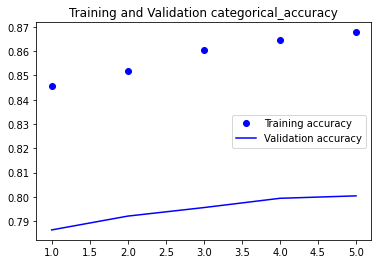

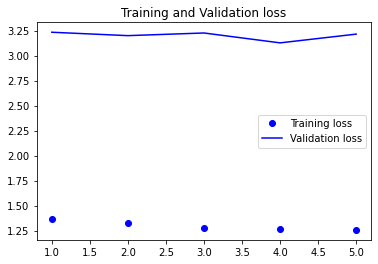

In [56]:
# optimizer 별로인듯..ㅜ-> d_model 잘못넣었었음
import matplotlib.pyplot as plt

epochs = range(1, len(val_acc_main) + 1)

plt.plot(epochs, train_acc_main, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_main, 'b', label = 'Validation accuracy')
plt.title('Training and Validation categorical_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss_main, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_main, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [57]:
sample_transformer.save_weights("model/transformer_QA_weights_repeat.h5")

In [70]:
import time
train_loss_main = []
val_loss_main = []
train_acc_main = []
val_acc_main = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if (batch+1) % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % (EPOCHS//5) == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        val_loss.reset_states()
        val_accuracy.reset_states()
        for inp, tar  in val_dataset:
            val_step(inp, tar)

        print(f'val-dataset result: Loss {val_loss.result():.4f} Accuracy {val_accuracy.result():.4f}')
        train_loss_main.append(train_loss.result())
        val_loss_main.append(val_loss.result())
        train_acc_main.append(train_accuracy.result())
        val_acc_main.append(val_accuracy.result())

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 100 Loss 10.2915 Accuracy 0.0421
Epoch 1 Batch 200 Loss 10.0897 Accuracy 0.1105
Epoch 1 Batch 300 Loss 9.7997 Accuracy 0.1305
Epoch 1 Batch 400 Loss 9.4306 Accuracy 0.1369
Epoch 1 Batch 500 Loss 8.9938 Accuracy 0.1446
Epoch 1 Loss 8.7989 Accuracy 0.1476
Time taken for 1 epoch: 140.87 secs

Epoch 2 Batch 100 Loss 6.1746 Accuracy 0.2787
Epoch 2 Batch 200 Loss 5.8148 Accuracy 0.3176
Epoch 2 Batch 300 Loss 5.6058 Accuracy 0.3281
Epoch 2 Batch 400 Loss 5.5107 Accuracy 0.3346
Epoch 2 Batch 500 Loss 5.3553 Accuracy 0.3530
Saving checkpoint for epoch 2 at ./checkpoints/train0/ckpt-1
val-dataset result: Loss 4.9189 Accuracy 0.4375
Epoch 2 Loss 5.2903 Accuracy 0.3606
Time taken for 1 epoch: 1269.49 secs

Epoch 3 Batch 100 Loss 4.5584 Accuracy 0.4257
Epoch 3 Batch 200 Loss 4.3641 Accuracy 0.4492
Epoch 3 Batch 300 Loss 4.2290 Accuracy 0.4623
Epoch 3 Batch 400 Loss 4.1667 Accuracy 0.4679
Epoch 3 Batch 500 Loss 4.0643 Accuracy 0.4793
Epoch 3 Loss 4.0259 Accuracy 0.4839
Time taken for 1

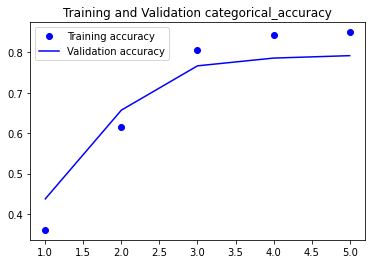

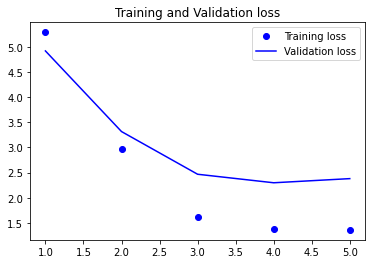

In [71]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_acc_main) + 1)

plt.plot(epochs, train_acc_main, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_main, 'b', label = 'Validation accuracy')
plt.title('Training and Validation categorical_accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss_main, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_main, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [72]:
sample_transformer.save_weights("model/transformer_QA_weights.h5")